In [2]:
import numpy as np
from math import sqrt

In [3]:
class FreshReplay:
    def add(self, x):
        self.exp = x
    def sample(self, b, m_e):
        return [self.exp], self.exp, [1 for _ in range(b)]

In [4]:
class UniformReplay:
    def __init__(self):
        self.exps = []
        self.exps_at_t = []
    def add(self, x):
        self.exps.append(x)
    def sample(self, b, m_e):
        indices = np.random.randint(low=0, high=len(self.exps), size=b)
        expectation = sum(self.exps) / len(self.exps)
        self.exps_at_t.append([self.exps[i] for i in indices])
        return [self.exps[i] for i in indices], expectation, [1 for _ in range(b)]

In [5]:
class PrioritisedReplay:
    def __init__(self, alpha=0.7, ns=1.0):
        self.exps = []
        self.exps_at_t = []
        self.distrib_at_t = []
        self.alpha = alpha
        self.ns = ns
    def add(self, x):
        self.exps.append((10,x)) # (Error, value)
    def sample(self, b, model_estimate):
        self.exps.sort(reverse=True)
        sampling_distrib = np.array([pow(1/(i+1), self.alpha) for i in range(len(self.exps))])
        sampling_distrib /= np.sum(sampling_distrib)
        indices = np.random.choice([i for i in range(len(self.exps))], p=sampling_distrib, size=b)
        sampled = [self.exps[i][1] for i in indices]
        # Update td error
        for i in indices:
            error = self.exps[i][1] - model_estimate
            if error < 0:
                error *= self.ns
            td_error = abs(error)
#             td_error = min(td_error, 0.001)
            current_exp = self.exps[i]
            self.exps[i] = (td_error, current_exp[1])
        # Expectation
        expectation = 0
        for p, d in zip(sampling_distrib, self.exps):
            expectation += float(p) * d[1]
        is_weights = [(1/(len(self.exps) * sampling_distrib[i])) for i in indices]
        max_wi = 1/(len(self.exps) * sampling_distrib[-1])
        normalised_is_weights = [w/max_wi for w in is_weights]
        
        normalised_is_weights = [1 for _ in normalised_is_weights]
        
        self.exps_at_t.append(sampled)
        self.distrib_at_t.append([(pa, wa[1]) for pa, wa in zip(sampling_distrib, self.exps)])
        
        return sampled, expectation, normalised_is_weights

In [6]:
class Model:
    def __init__(self, lr):
        self.lr = lr
        self.estimate = 0
    def output(self):
        return self.estimate
    def train(self, xs, weights):
        batch_error = 0
        for x, w in zip(xs, weights):
            batch_error += w * (self.estimate - x)
        self.estimate -= self.lr * (batch_error / len(xs))

In [139]:
dataset = [1/sqrt(n + 1) for n in range(0,100, 10)]
timesteps = 100
t_max_extra = (10) * timesteps

In [140]:
def get_estimates(replay, model_lr=0.01, batch_size=1):

    model = Model(model_lr)

    model_estimates = []
    replay_expecatations = []
    model_estimate = model.output()
    model_estimates.append(model_estimate)
    for d in dataset:
        replay.add(d)
        for _ in range(timesteps):
            xs, e, ws = replay.sample(batch_size, model_estimate)
            model.train(xs, ws)
            model_estimate = model.output()
            model_estimates.append(model_estimate)
            replay_expecatations.append(e)
            
    for _ in range(t_max_extra):
        xs, e, ws = replay.sample(batch_size, model_estimate)
        model.train(xs, ws)
        model_estimate = model.output()
        model_estimates.append(model_estimate)
        replay_expecatations.append(e)

    return model_estimates, replay_expecatations

In [141]:
model_lr = 0.1

In [142]:
batch_size = 1

In [143]:
fresh_estimates, fresh_exps = get_estimates(FreshReplay(), model_lr, batch_size)
uniform_replay = UniformReplay()
uniform_estimates, uniform_exps = get_estimates(uniform_replay, model_lr, batch_size)
p_replay = PrioritisedReplay(alpha=0.75)
p_estimates, p_exps = get_estimates(p_replay, model_lr, batch_size)

In [144]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

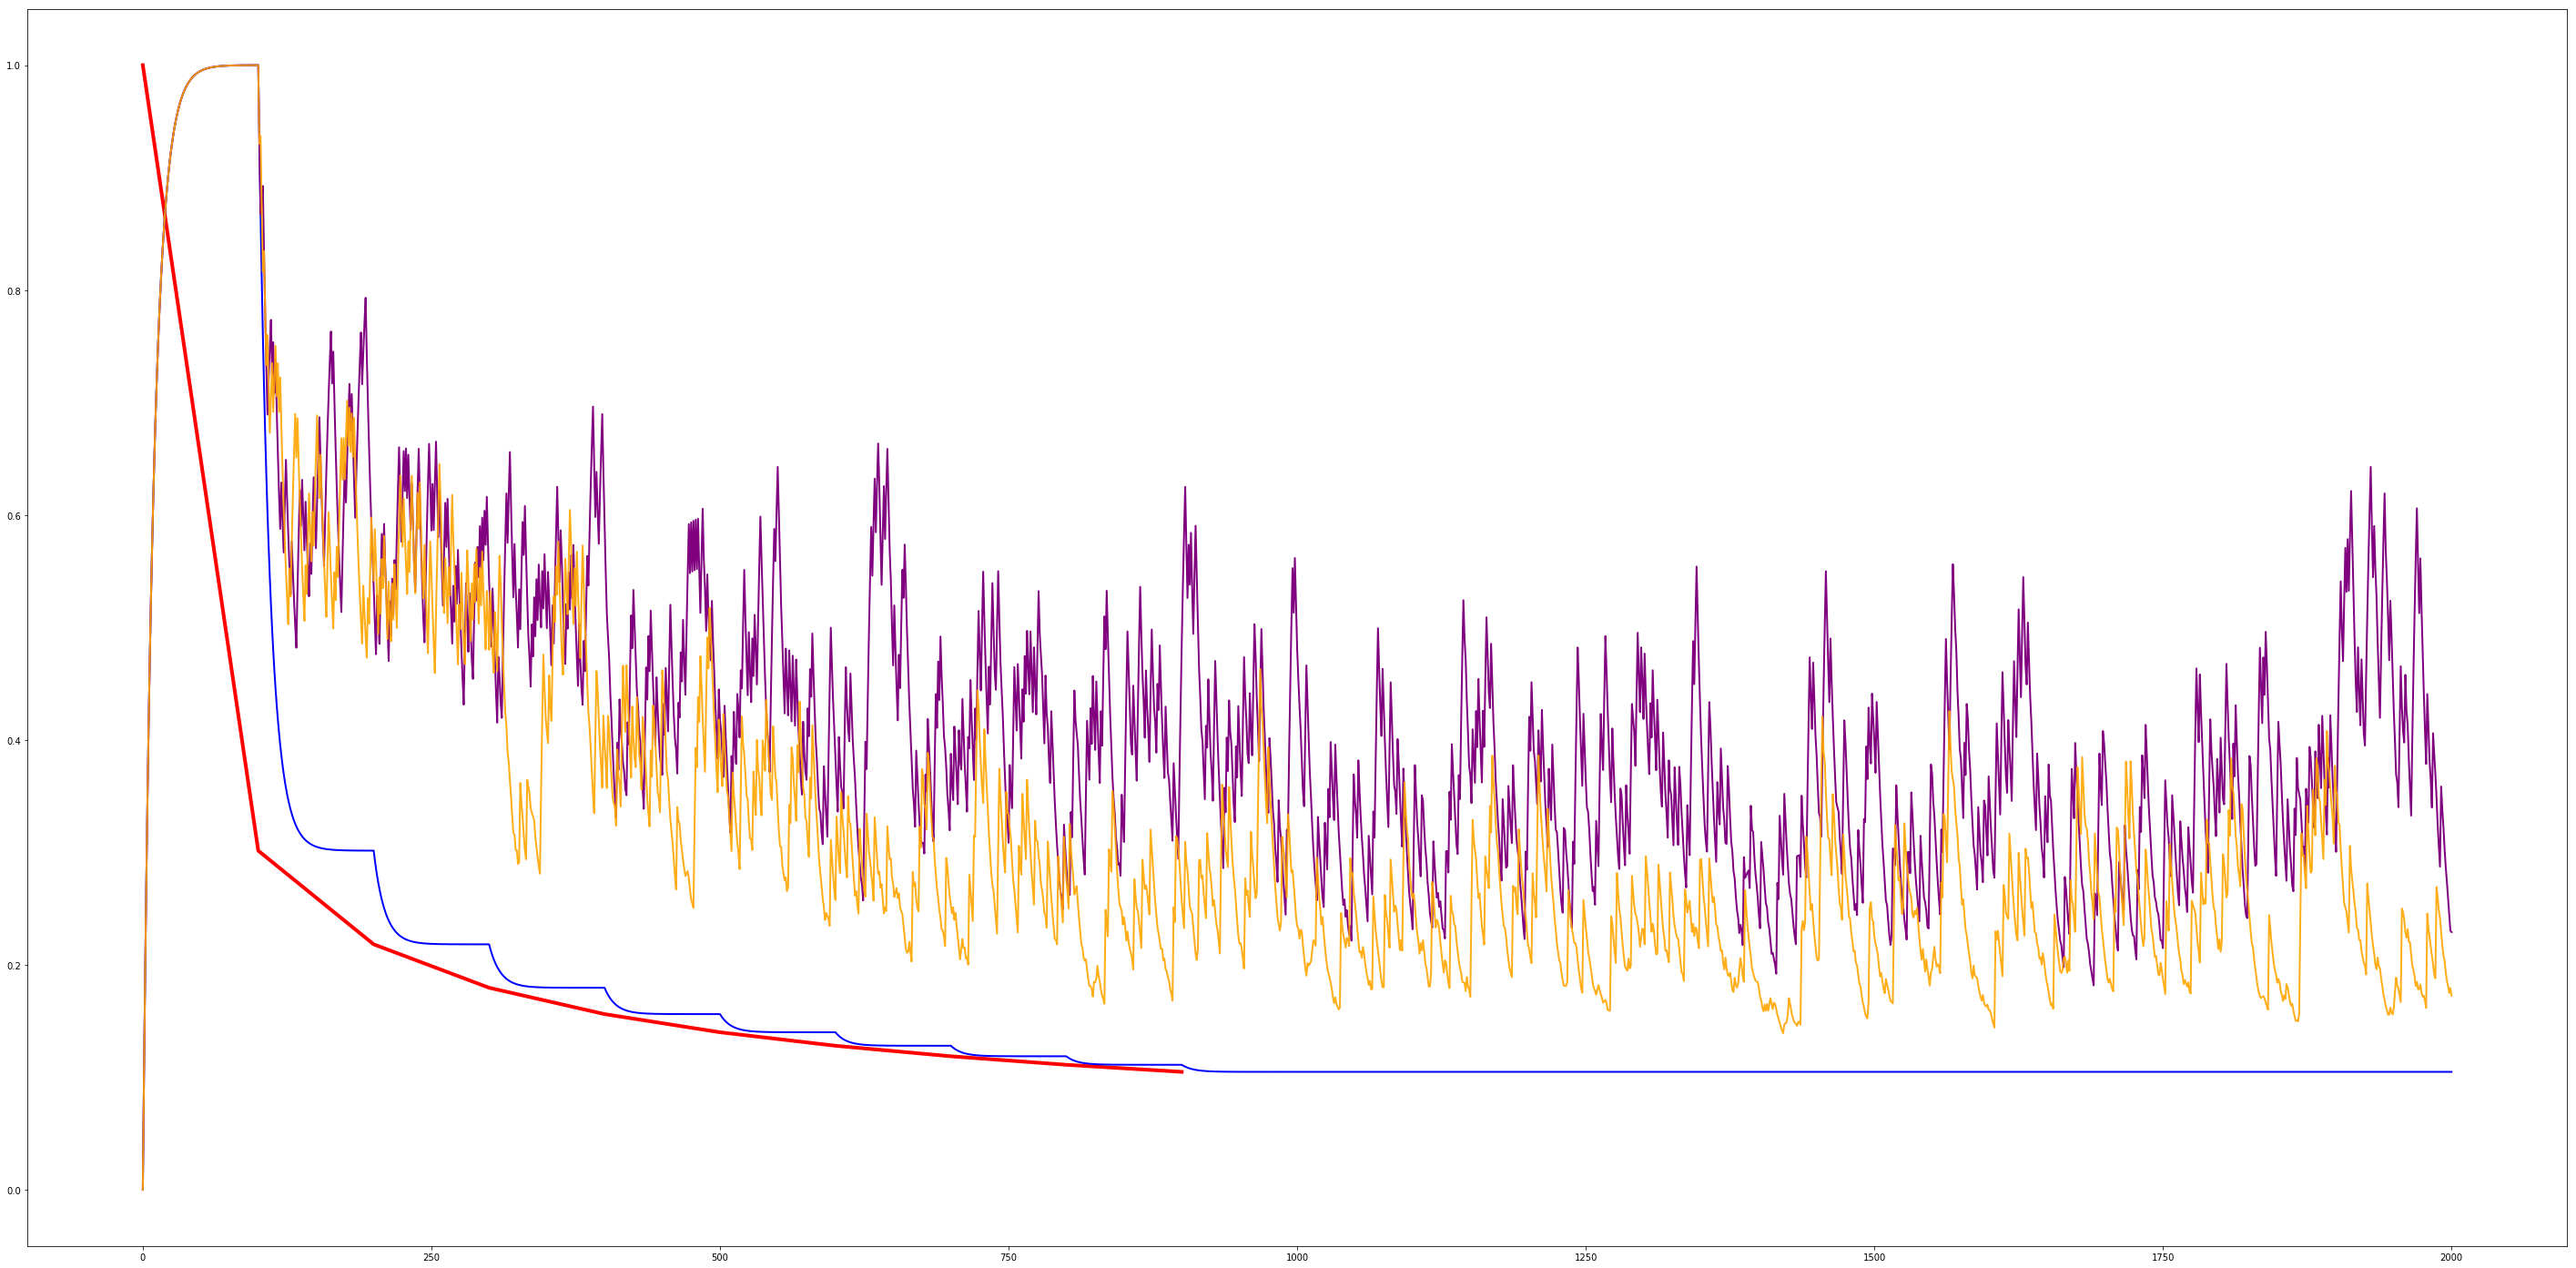

In [145]:
plt.figure(figsize=(50,25))
# Ground truth
plt.plot([i*timesteps for i in range(len(dataset))], dataset, color="r", linewidth=4)

plt.plot([i for i in range(len(fresh_estimates))], fresh_estimates, color="b", linewidth=2)

# plt.plot([i for i in range(len(uniform_estimates))], uniform_estimates, color="g", linewidth=2)

plt.plot([i for i in range(len(p_estimates))], p_estimates, color="purple", linewidth=2)

plt.plot([i for i in range(len(uniform_estimates))], uniform_estimates, color="orange", alpha=0.9,linewidth=2)

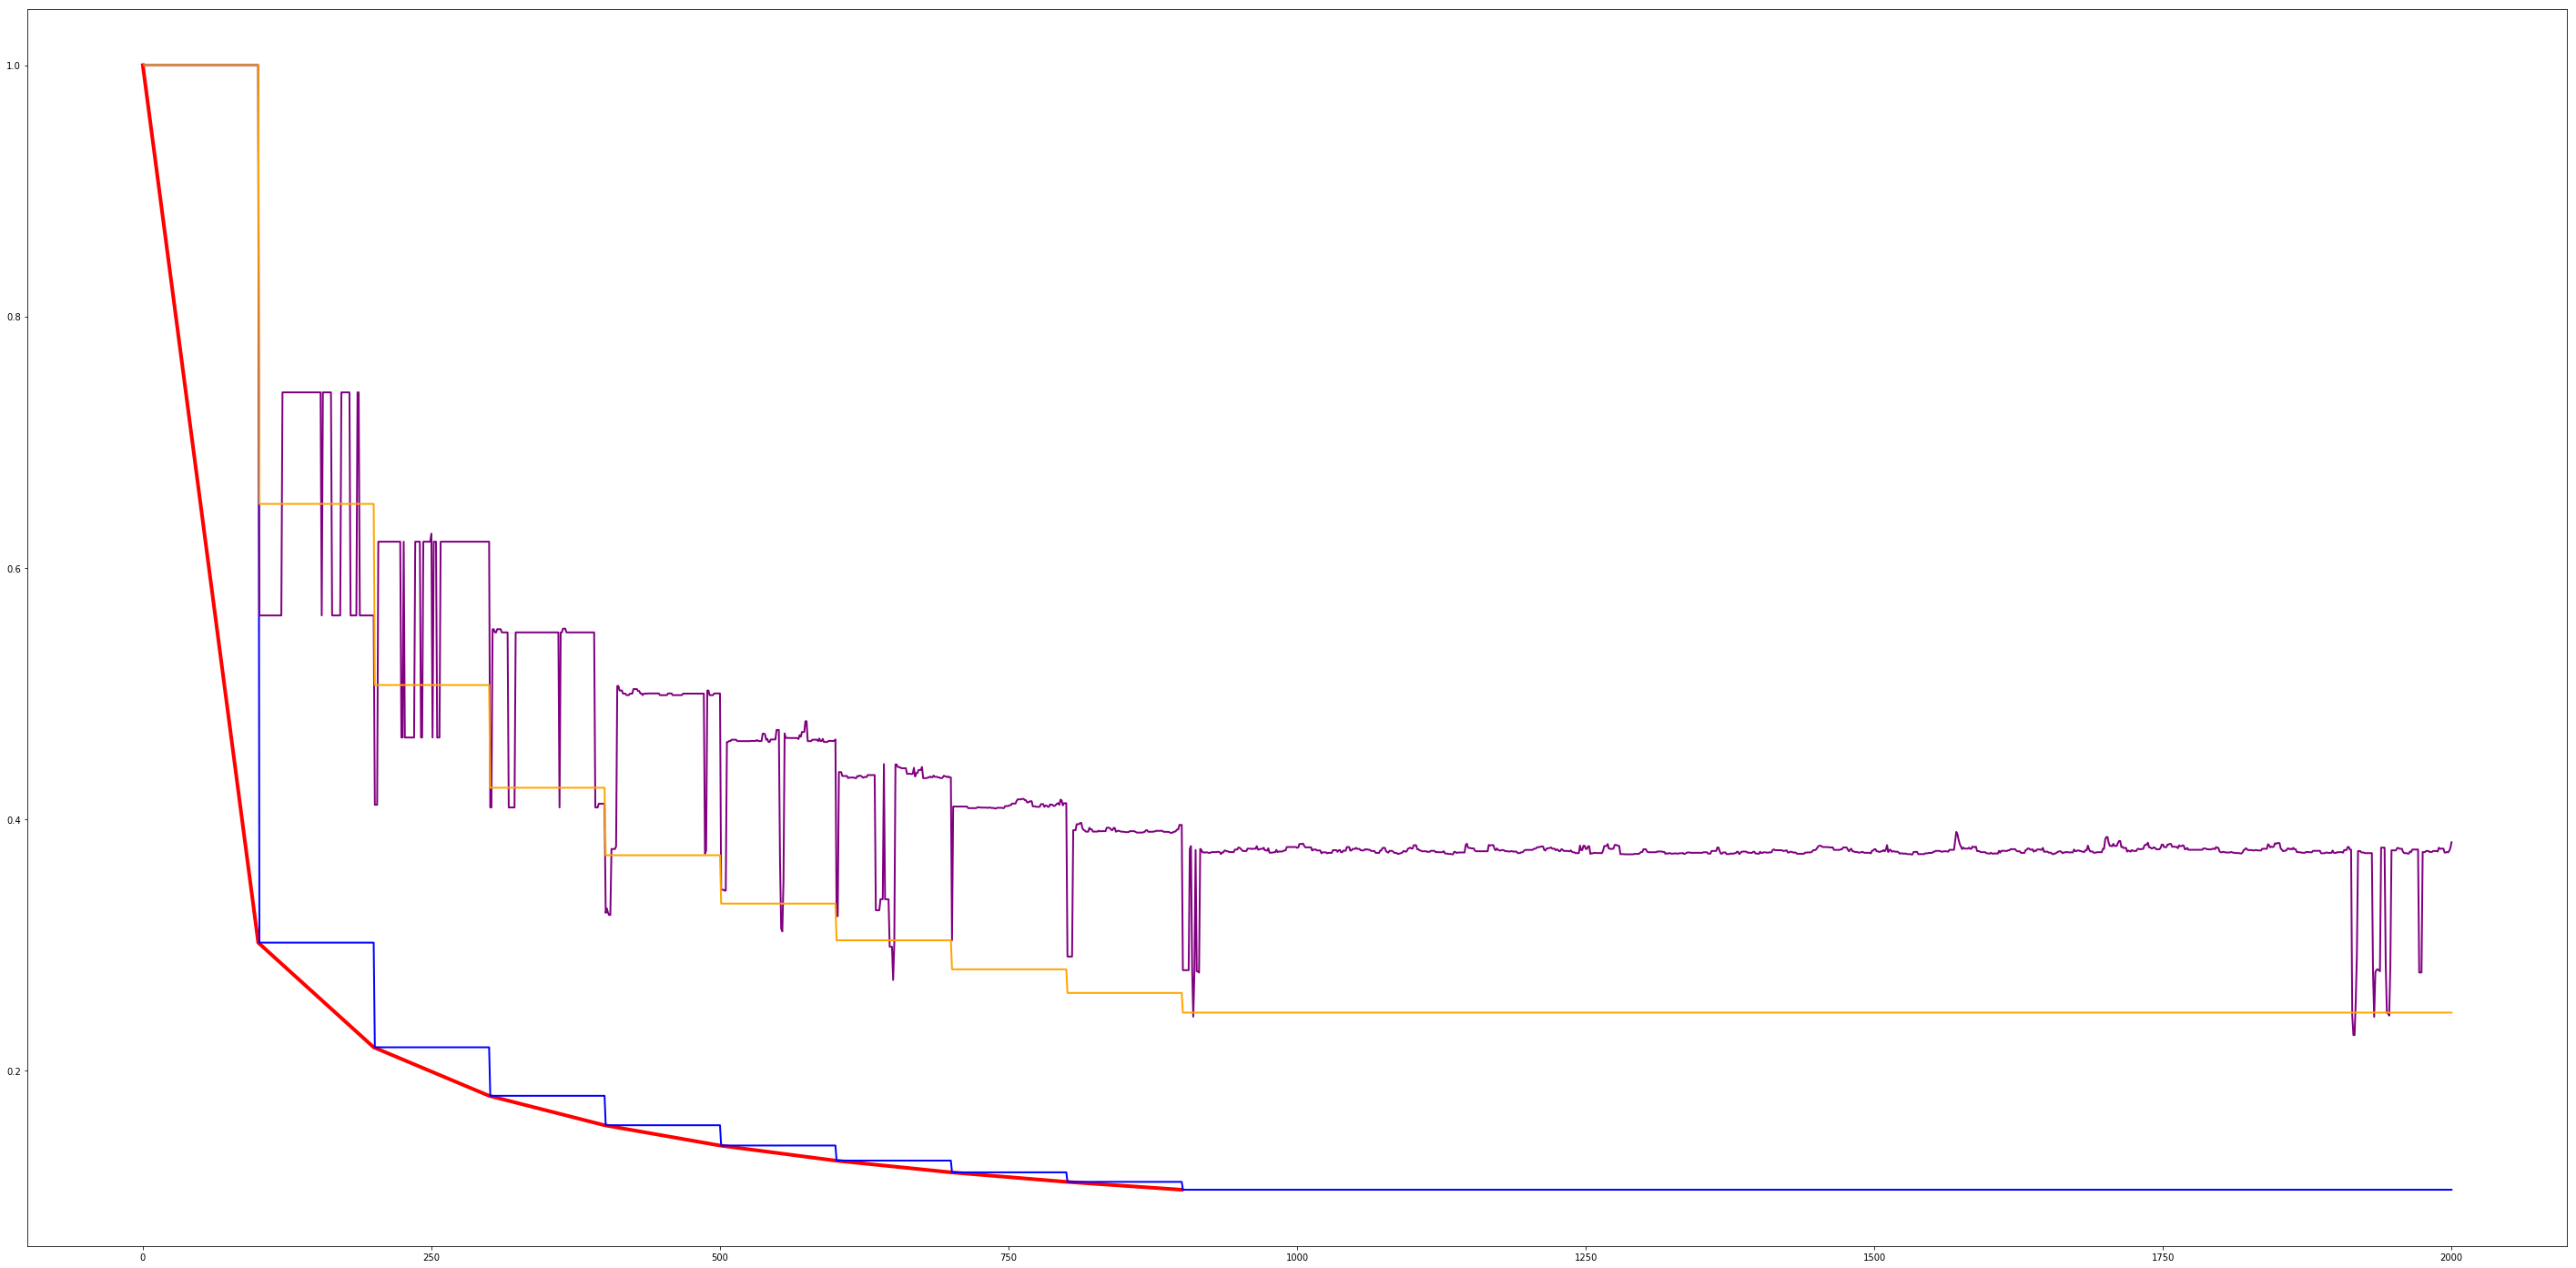

In [146]:
plt.figure(figsize=(50,25))
# Ground truth
plt.plot([i*timesteps for i in range(len(dataset))], dataset, color="r", linewidth=4)

plt.plot([i + 1 for i in range(len(fresh_exps))], fresh_exps, color="b", linewidth=2)

# plt.plot([i for i in range(len(uniform_estimates))], uniform_estimates, color="g", linewidth=2)

plt.plot([i + 1 for i in range(len(p_exps))], p_exps, color="purple", linewidth=2)

plt.plot([i + 1 for i in range(len(uniform_exps))], uniform_exps, color="orange", linewidth=2)

In [147]:
from mpl_toolkits.mplot3d import Axes3D

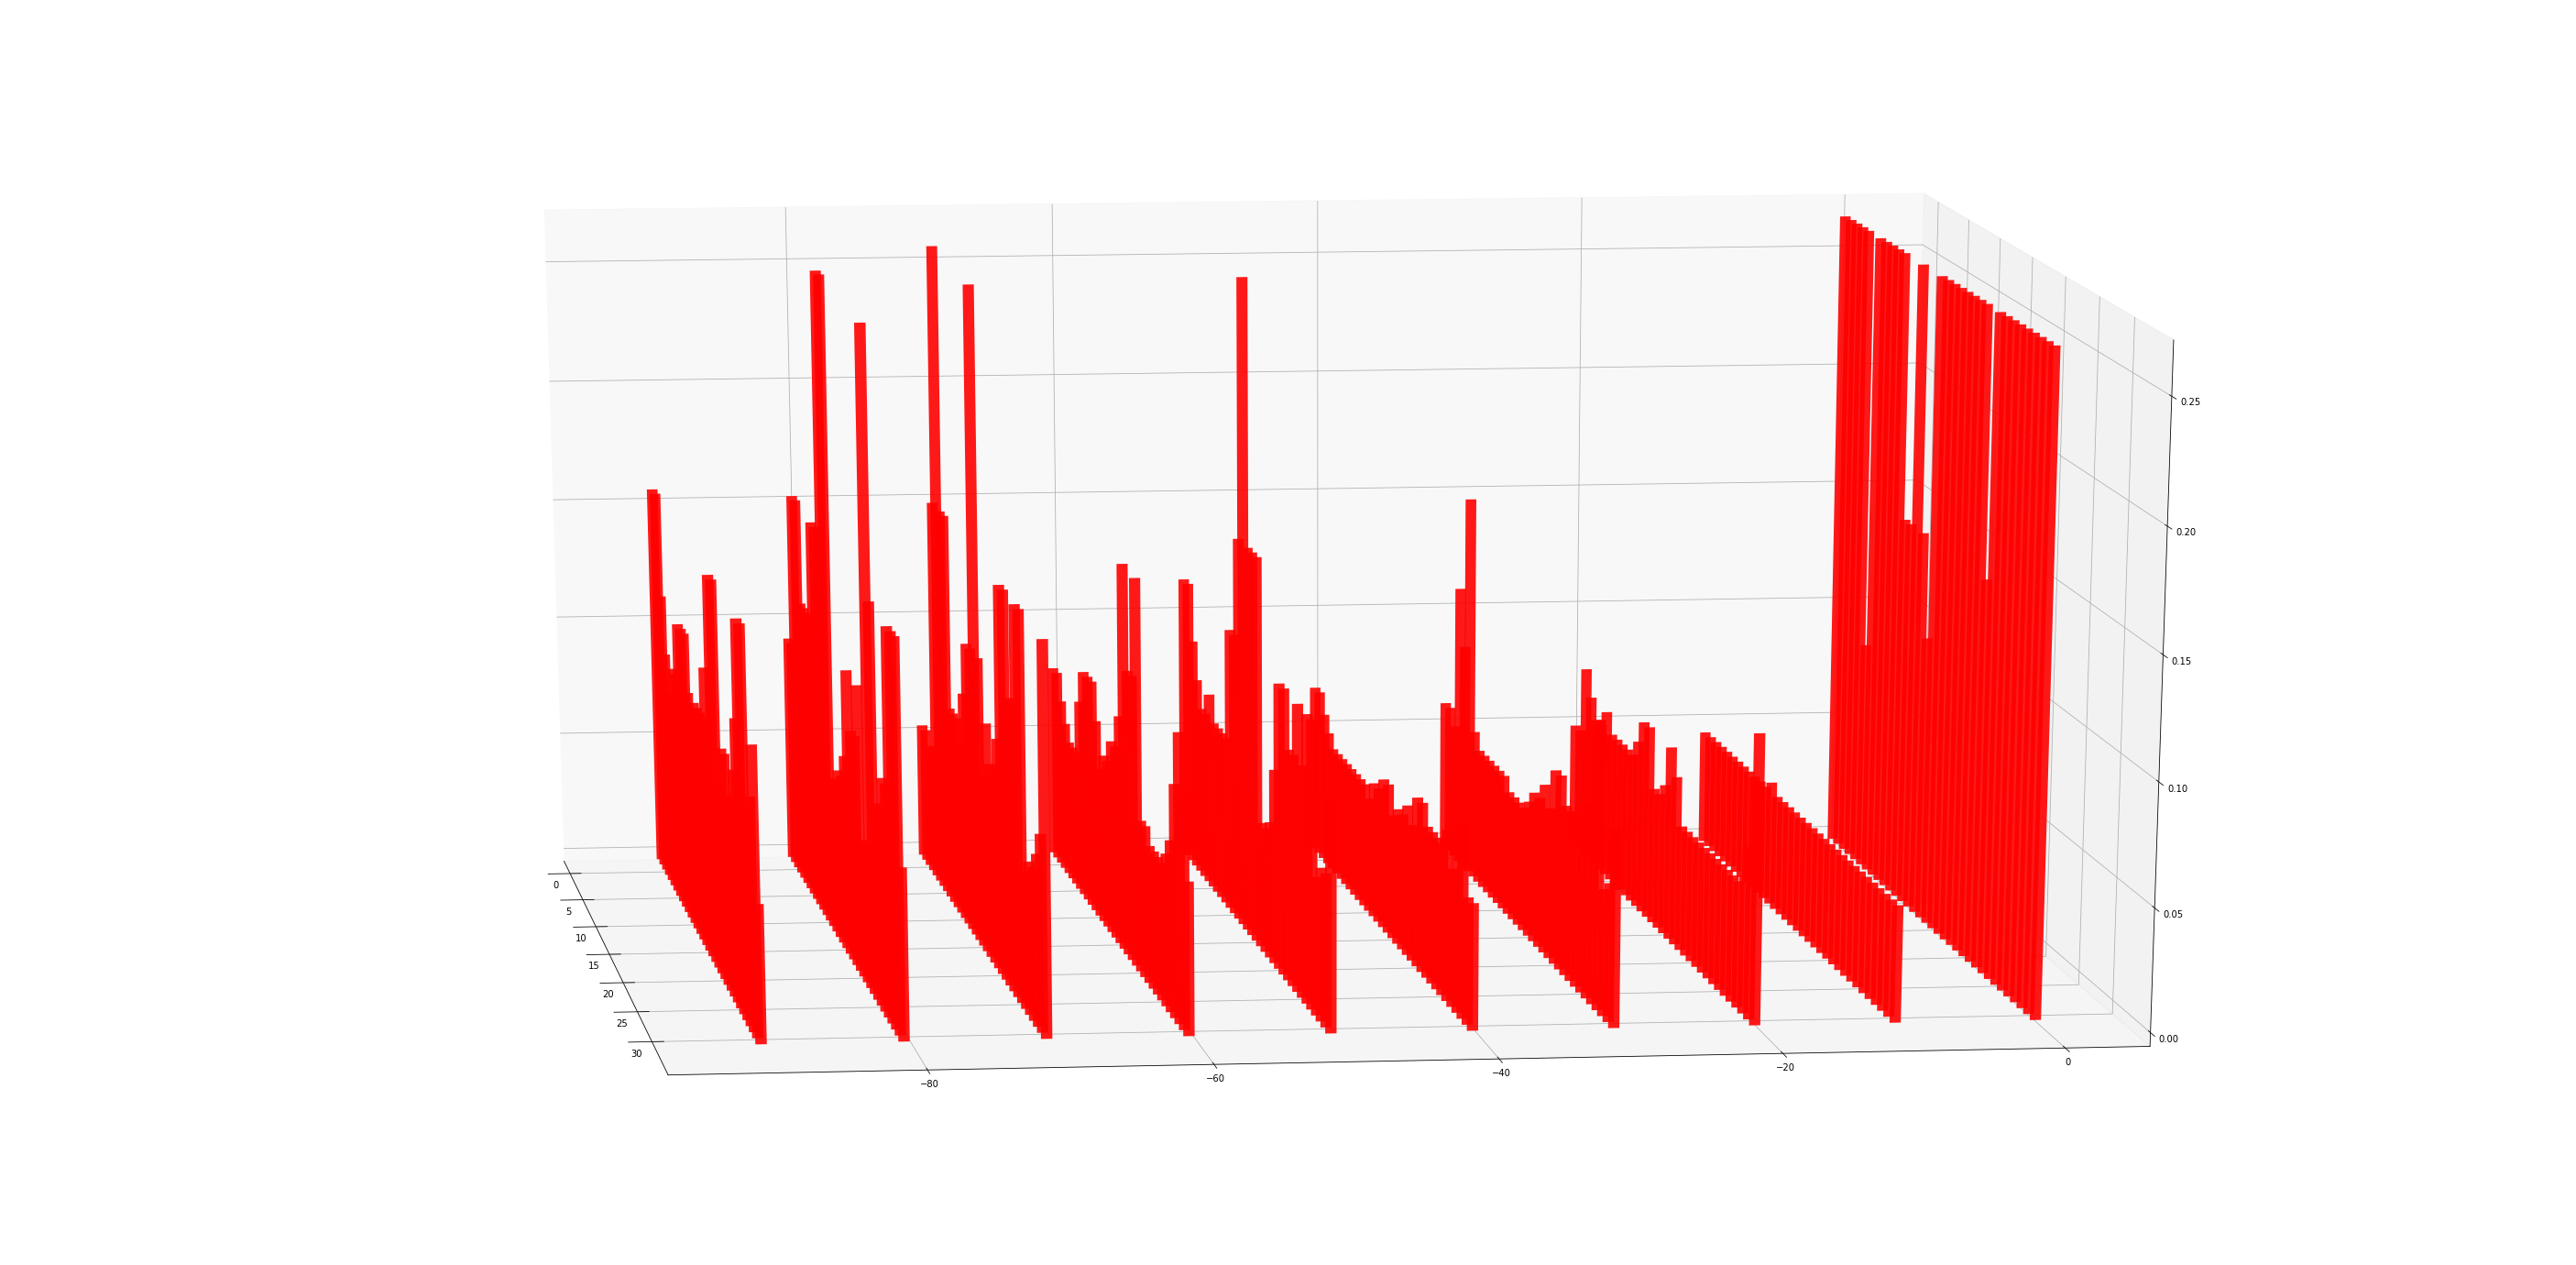

In [148]:
fig = plt.figure(figsize=(50,25))
ax = fig.add_subplot(111, projection="3d")

distribs = [p for i, p in enumerate(p_replay.distrib_at_t[-100:]) if i % 3 == 0]
# print(distribs)
# distribs = p_replay.distrib_at_t[0: 2000]

x_points = []
y_points = []
z_points = []

for x in range(len(distribs)):
#     missing = 20 - len(distribs[x])
    zs = distribs[x]
#     print(zs)
#     zs += [0 for _ in range(missing)]
    cc = []
    vv = []
    ic = 0
    for v, c in zs:
        cc.append(-1/(c**2))
#         cc.append(c)
        ic+=1
        vv.append(v)
    ax.bar(cc,vv,zs=x, zdir="x", alpha=0.9, color="r")
#     break
    for z, y in zs:
#         print(y, z)
        x_points.append(x)
        y = -1/(y**2)
        y_points.append(y)
#         z = np.log(z)
        z_points.append(z)

#     for z, y in reversed(zs):
# #         print(y, z)
#         x_points.append(x)
#         y = -1/(y**2)
#         y_points.append(y)
# #         z = np.log(z)
#         z_points.append(z)

# x_points = [x * 100 for x in x_points]
# y_points = [y * 100 for y in y_points]
# z_points = [z * 100 for z in z_points]

ax.view_init(15, -7)

# print(distribs[-1])

# X, Y = np.meshgrid(x_points, y_points)
# ax.scatter(x_points, y_points, z_points, color="b")
# ax.plot_wireframe(x_points, y_points, z_points)
# ax.contour(x_points, y_points, z_points)

In [149]:
p_replay.distrib_at_t[-1]

[(0.26598321840416522, 1.0),
 (0.15815456789877799, 0.11867816581938533),
 (0.11668453387439631, 0.2182178902359924),
 (0.094039268707703877, 0.14002800840280097),
 (0.079547536293193249, 0.1796053020267749),
 (0.069381038947104068, 0.1111111111111111),
 (0.061806009837308315, 0.12803687993289598),
 (0.055916083718427087, 0.10482848367219183),
 (0.051188494248522599, 0.15617376188860607),
 (0.047299248070401291, 0.30151134457776363)]

In [150]:
from bokeh.plotting import figure, output_notebook, show
output_notebook()

Loading BokehJS ...

In [162]:
from bokeh.palettes import magma, inferno, Set1, Set3, Paired, Dark2, Set2, Pastel1, Pastel2

In [159]:
from bokeh.charts import Bar

In [165]:
nums = 8

In [168]:
colors = Pastel1[nums]

In [174]:
p = figure(width=1400, height=800, title="Non-Stationary Bandit")

for index in range(nums):
    i = -(index+1)
    to_graph = p_replay.distrib_at_t[i*1]
    sort_list = sorted(to_graph, key=lambda x: x[1], reverse=True)

    x = list(map(lambda x: x[1], sort_list))
    y = list(map(lambda x: x[0], sort_list))
    
#     print(len(x))

#     p.line([i+1 for i in range(len(y))], y, color=colors[index], line_width=2)
    p.vbar([i+1 + index*(1/(nums*1.2)) for i in range(len(y))], 1/(nums *2), y, color=colors[index], line_color="black", line_width=0.5)
    
p.xaxis.axis_label = "Experience"
p.yaxis.axis_label = "Probability of sampling"
show(p)